d_fits/sub571226_095.fits
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs

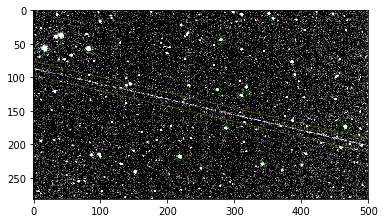

[7.52225414]
Complete!


In [14]:
###  単体のファイルでphotometryをする
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import astropy.wcs
from astropy.io import fits
import astropy.io
from astropy.stats import sigma_clipped_stats
from photutils import datasets
from photutils import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
from photutils import RectangularAperture
from photutils import CircularAnnulus
from scipy.optimize import curve_fit
from photutils import aperture_photometry
from matplotlib.backends.backend_pdf import PdfPages

#ファイルを一つしていしてphotmetry を行う
#########################################################################
#ID_Number
ID = "sub571226_095.fits"
#IDの該当するindexをdfから抽出
#んで残りは普通にphotometry
#########################################################################
df = pd.read_csv("simultaneous_event_candidates_table_MU+Tomo-e7.csv")
meteor_flux_list = df["flux_meteor"].values
ID_list = df["ID"]
ID_list_fits = "sub" + df["ID"] + ".fits"
for i in range(len(ID_list_fits)):
    if ID_list_fits[i] == ID:
        ID_index = i
meteor_flux = meteor_flux_list[ID_index]
filename_fits = "d_fits/" + ID_list_fits[ID_index]
filename_xml = "d_xml/sub" + ID_list[ID_index] + ".xml"
print filename_fits

def gauss(x, A, mu, sigma):
    return A / np.sqrt(2.0*np.pi) / sigma * np.exp(-((x-mu)/sigma)**2/2)

with open("d_xml/sub571226_095.xml") as f: #ここは別にID関係ない
    a = f.readlines()
    b = a[50]#<TABLEDATA>
    c = a[77] #</TABLEDATA>
    
mag_vr = np.arange(1).reshape(1) #starと比較して最終的に流星のmag_videorateが欲しい
###################################### xml ファイルの読み込み #######
#################################恒星の(ra, dec, Vmag)のリストにする###
with open(filename_xml) as f:
    l = f.readlines()
    for i in range(len(l)):
        m = l[i]
        if m == b:
            del_start = i + 1
        elif m == c:
            del_end = i
l = l[del_start:del_end]
xml = l[0]
xml = re.split('<TR><TD>|</TD><TD>|</TD></TR>', xml)
del xml[0],xml[2:8],xml[3:]
for i in l:
    s = re.split('<TR><TD>|</TD><TD>|</TD></TR>', i)
    del s[0],s[2:8],s[3:]
    xml = np.vstack((xml, s))
xml = np.delete(xml,0, 0)
xml = xml.astype(np.float64)
##############################################################
######################## World Coordinates System to Pixel Coordinates ###
pixel_coordinates = np.arange(2).reshape(1,2)
fits = astropy.io.fits.open(filename_fits)
hdul = fits
data = hdul[0].data
data2 = data[1,:,:]#差分前のフレームだけにする
data2 = np.reshape(data2, (282, 500))#2次元化
wcs = astropy.wcs.WCS(fits[0].header, naxis = 2)
for j in range(len(xml)):
        pixel_coord = wcs.all_world2pix(xml[j,0], xml[j,1], 1)
        pixel_coordinates = np.vstack((pixel_coordinates, pixel_coord))
pixel_coordinates = np.delete(pixel_coordinates,0, 0)
###############################################################
################################# Remove the stars outside the frame ###
index = np.arange(1).reshape(1)
for i in range(len(pixel_coordinates)):
    x = pixel_coordinates[i,0]
    y = pixel_coordinates[i,1]
    if (x < 0) or (x > 490) or (y < 0) or (y > 282):
#x座標が490なのはガウスフィットするときに±10pix抜き出すからはみ出ないように490に設定
        index = np.vstack((index, i))
index = np.delete(index,0, 0)
pixel_coordinates = np.delete(pixel_coordinates,index, 0)
xml = np.delete(xml,index, 0)
vmag = xml[:,2]
###############################################################
############ Gaussian profile of catalog stars to estimate aperture's parameters ###
star_flux = np.arange(1).reshape(1)
for i in range(len(pixel_coordinates)):
    xr1 = pixel_coordinates[i,0] - 10
    xr2 = pixel_coordinates[i,0] + 10
    xr1 = xr1.astype(int)
    xr2 = xr2.astype(int)
    xr = range(xr1, xr2, 1)
    yr = pixel_coordinates[i,1]
    yr = yr.astype(int)
    y =  data2[yr,xr]
    A_para = y.max()
    mu_para = pixel_coordinates[i,0]
    p0 = [A_para, mu_para, 1.] # パラメータの初期値(A, mu, sigma)
    parameter,_ = curve_fit(gauss, xr, y, p0=p0)
    sigma = parameter[2]
    fwhm = 2*parameter[2]*(np.sqrt(2*np.log(2)))
    xx = np.linspace(xr1, xr2, 100)
    yy = gauss(xx, *parameter)
############################################    #ax = plt.subplot()
############################################    #ax.plot(xr, y, 'c.')
############################################    #ax.plot(xx, yy, 'r-')
############################################    #plt.show()
############################################    #file_name = star_photometry_filename[i]
############################################   #plt.savefig(file_name)  
##################################################################
####################################### Conducting aperture photometry ###
    positions = pixel_coordinates[i,:]
    aperture_radius = 1.5*fwhm
    inner_radius = aperture_radius + fwhm
    outer_radius = 5*fwhm
    apertures = CircularAperture(positions, r=aperture_radius)
    annulus_apertures = CircularAnnulus(positions, r_in=inner_radius, r_out=outer_radius)
    apers = [apertures, annulus_apertures]
    phot_table = aperture_photometry(data2, apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    bkg_mean = phot_table['aperture_sum_1'] / annulus_apertures.area()
    bkg_sum = bkg_mean * apertures.area()
    final_sum = phot_table['aperture_sum_0'] - bkg_sum
    phot_table['residual_aperture_sum'] = final_sum
    phot_table['residual_aperture_sum'].info.format = '%.8g'
    aperture_sum = np.array(phot_table["residual_aperture_sum"][:])
    star_flux = np.vstack((star_flux, aperture_sum))
star_flux = np.delete(star_flux,0, 0)
if len(xml)==0: #カタログ恒星がすべてフレーム外だった場合
        xml = np.zeros((1,3))
        star_flux = np.zeros((1,1))
xml = np.hstack((xml,star_flux))
###################################################################
####################################  Comparison star flux and meteor flux ###
m_vr = np.arange(1).reshape(1)
for i in range(len(xml)):
    video_rate_magnitude = xml[i,2] - 2.5*np.log10(meteor_flux/xml[i,3])
    m_vr = np.vstack((m_vr, video_rate_magnitude))
m_vr = np.delete(m_vr,0, 0)
print "aaa",m_vr
m_average = np.average(m_vr)
deviation = m_vr - m_average
deviation = np.power(deviation,2)
dispersion = np.sqrt(np.sum(deviation)/len(m_vr))
mag_vr = np.hstack((mag_vr,m_average))
mag_vr = np.delete(mag_vr,0, 0)
###############################################################  絶対等級
alt = df["Beginning_height_km_"].values #[km]
alt = alt[ID_index]
#alt = alt*10**3
distance = 170
#distance = 170*10**3 #[km]
alt = np.power(alt, 2)
distance = np.power(distance, 2)
l = alt + distance
l = l.astype(np.float64)
l = np.sqrt(l)
#pc = l/(3.085677581*10**6)
#abs_mag = mag_vr + 5 - 5*np.log10(pc)
abs_mag = mag_vr + 10 - 5*np.log10(l)
####################################################################
positions = (pixel_coordinates[:,0],pixel_coordinates[:,1])
apertures = CircularAperture(positions, r=6.)
rotation_angle = np.deg2rad(90-77)
rectangular = RectangularAperture((287,153), w=600., h=20., theta=rotation_angle)
plt.imshow(data2, cmap = 'gray', vmin = 0, vmax = 400, interpolation = 'none')
apertures.plot(color='green', lw=1.5, alpha=50.5)
rectangular.plot(color='yellow', lw=0.5, alpha=10.5)
#plt.ylim(0, 282)
pdf = PdfPages('test.pdf') #図をpdfに出力
pdf.savefig()
pdf.close()
plt.show()
####################################################################
print mag_vr
print "Complete!"
### aperture内に他のsourceがある場合、除く
### 流星の飛跡付近のマスキング
### 